# Incubator State Estimation with a Particle Filter

This uses `pypfilt` to implement the filtering on the incubator example.

In [2]:
%%writefile incubator_model.py

# If you change this file, you should restart the kernel, otherwise the changes will not be reflected in the simulation

from pypfilt import OdeModel
import sympy as sp
import numpy as np

# Parameters
C_air = sp.Symbol("C_air", real=True)  # Specific heat capacity
G_box = sp.Symbol("G_box", real=True)  # Specific heat capacity
C_heater = sp.Symbol("C_heater", real=True)  # Specific heat capacity
G_heater = sp.Symbol("G_heater", real=True)  # Specific heat capacity

# Constants
V_heater = sp.Symbol("V_heater", real=True)
i_heater = sp.Symbol("i_heater", real=True)

# Inputs
in_room_temperature = sp.Symbol("T_room", real=True)
on_heater = sp.Symbol("on_heater", real=True)

# States
T = sp.Symbol("T", real=True)
T_heater = sp.Symbol("T_heater", real=True)

power_in = on_heater * V_heater * i_heater

power_transfer_heat = G_heater * (T_heater - T)

total_power_heater = power_in - power_transfer_heat

power_out_box = G_box * (T - in_room_temperature)

total_power_box = power_transfer_heat - power_out_box

der_T_heater = (1.0 / C_heater) * (total_power_heater)
der_T = (1.0 / C_air) * (total_power_box)

# Vectorize der_T and der_T_heater so they can be applied to the particles
der_T_heater_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T_heater)
der_T_function = sp.lambdify((T_heater, T, C_air, G_box, C_heater, G_heater, V_heater, i_heater, in_room_temperature, on_heater), der_T)



class IncubatorModel(OdeModel):

    def field_types(self, ctx):
        r"""
        Define the state vector :math:`[\sigma, \rho, \beta, x, y, z]^T`.
        """
        return [
            ('T_heater', float),
            ('T', float),
            ('C_air', float),
            ('G_box', float),
            ('C_heater', float),
            ('G_heater', float),
            ('V_heater', float),
            ('i_heater', float)
        ]

    def d_dt(self, time, xt, ctx, is_forecast):
        """
        The right-hand side of the ODE system.

        :param time: The current time.
        :param xt: The particle state vectors.
        :param ctx: The simulation context.
        :param is_forecast: True if this is a forecasting simulation.
        """

        # TODO: Lookup inputs
        T_room = 20.0
        on_heater = 0.0

        rates = np.zeros(xt.shape, xt.dtype)

        rates['T_heater'] = der_T_heater_function(xt['T_heater'], xt['T'], xt['C_air'], xt['G_box'], xt['C_heater'], xt['G_heater'], xt['V_heater'], xt['i_heater'], T_room, on_heater)
        rates['T'] = der_T_function(xt['T_heater'], xt['T'], xt['C_air'], xt['G_box'], xt['C_heater'], xt['G_heater'], xt['V_heater'], xt['i_heater'], T_room, on_heater)

        return rates

Overwriting incubator_model.py


In [3]:
%%writefile incubator_obs.py

from pypfilt.obs import Univariate
import scipy.stats

class ObsIncubator(Univariate):

    def distribution(self, ctx, snapshot):
        expect = snapshot.state_vec['T']
        return scipy.stats.norm(loc=expect, scale=0.1)


Overwriting incubator_obs.py


In [4]:
%%writefile incubator_simulate.toml

[components]
model = "incubator_model.IncubatorModel"
time = "pypfilt.Scalar"
sampler = "pypfilt.sampler.LatinHypercube"
summary = "pypfilt.summary.HDF5"

[time]
start = 0.0
until = 100.0
steps_per_unit = 10
summaries_per_unit = 10

[prior]
T_heater = { name = "constant", args.value = 100.0 }
T = { name = "constant", args.value = 100.0 }
C_air = { name = "constant", args.value = 68.0 }
G_box = { name = "constant", args.value = 0.74 }
C_heater = { name = "constant", args.value = 243.0 }
G_heater = { name = "constant", args.value = 0.87 }
V_heater = { name = "constant", args.value = 12.0 }
i_heater = { name = "constant", args.value = 10.45 }

[observations.T]
model = "incubator_obs.ObsIncubator"

[filter]
particles = 500
prng_seed = 2001
history_window = -1
resample.threshold = 0.25

[scenario.simulate]

Overwriting incubator_simulate.toml


In [5]:
import pypfilt

scenario_file = 'incubator_simulate.toml'
instances = list(pypfilt.load_instances(scenario_file))
assert len(instances) == 1
instance = instances[0]
instance

Instance(scenario_id="simulate", descriptor="")

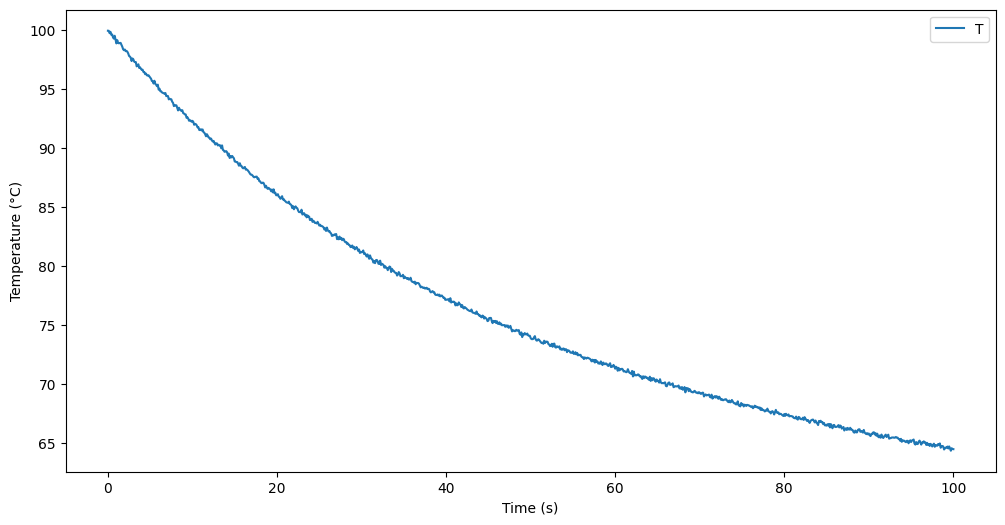

In [6]:
import matplotlib.pyplot as plt

# Simulate observations for T and T_heater.
obs_tables = pypfilt.simulate_from_model(list(pypfilt.load_instances(scenario_file))[0])

# Plot the backcast and forecast against the simulated observations.
plt.figure(figsize=(12, 6))
plt.plot(obs_tables['T']['time'], obs_tables['T']['value'], label='T')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [8]:
from data_handling import *

# Load the data
time_unit = 'ns'
data, _ = load_data("./lid_opening_experiment_jan_2021/lid_opening_experiment_jan_2021.csv",
                    desired_timeframe=(- math.inf, math.inf),
                    time_unit=time_unit,
                    normalize_time=False,
                    convert_to_seconds=True)
events = pandas.read_csv("./lid_opening_experiment_jan_2021/events.csv")
events["timestamp_ns"] = pandas.to_datetime(events["time"], unit=time_unit)

data

NameError: name 'HEATER_VOLTAGE' is not defined

In [7]:
# Load the data
time_unit = 'ns'
data, _ = load_data("./lid_opening_experiment_jan_2021/lid_opening_experiment_jan_2021.csv",
                    desired_timeframe=(- math.inf, math.inf),
                    time_unit=time_unit,
                    normalize_time=False,
                    convert_to_seconds=True)
events = pandas.read_csv("./lid_opening_experiment_jan_2021/events.csv")
events["timestamp_ns"] = pandas.to_datetime(events["time"], unit=time_unit)

data

NameError: name 'load_data' is not defined

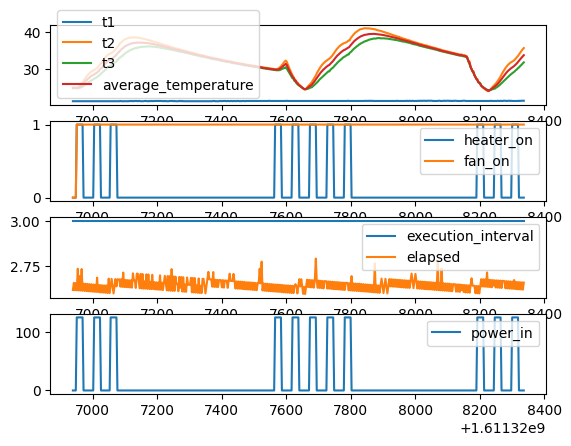

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

ax1.plot(data["time"], data["t1"], label="t1")
ax1.plot(data["time"], data["t2"], label="t2")
ax1.plot(data["time"], data["t3"], label="t3")
ax1.plot(data["time"], data["average_temperature"], label="average_temperature")
ax1.legend()

ax2.plot(data["time"], data["heater_on"], label="heater_on")
ax2.plot(data["time"], data["fan_on"], label="fan_on")
ax2.legend()

ax3.plot(data["time"], data["execution_interval"], label="execution_interval")
ax3.plot(data["time"], data["elapsed"], label="elapsed")
ax3.legend()

ax4.plot(data["time"], data["power_in"], label="power_in")
ax4.legend()

In [ ]:
events

,time,event,timestamp_ns
0,1611327598000000000,Lid Opened,2021-01-22 14:59:58
1,1611327658000000000,Lid Closed,2021-01-22 15:00:58
2,1611328159000000000,Lid Opened,2021-01-22 15:09:19
3,1611328225000000000,Lid Closed,2021-01-22 15:10:25


In [ ]:
# Inputs to _plant
measurements_heater = np.array([1.0 if b else 0.0 for b in data["heater_on"]])
measurements_Troom = data["t1"].to_numpy()

# System state measurements (partial)
measurements_T = data["average_temperature"].to_numpy()

kalman_prediction = []
kalman_prediction_prior_T = []
kalman_process_noise_Theater = []
kalman_process_noise_T = []
kalman_process_noise_Theater_prior = []
kalman_process_noise_T_prior = []
for i in range(len(measurements_heater)):
    f.predict(u=np.array([
            [measurements_heater[i]],
            [measurements_Troom[i]]
        ]))
    f.update(np.array([[measurements_T[i]]]))
    x = f.x
    kalman_process_noise_Theater_prior.append(np.sqrt(f.P_prior[0,0]))
    kalman_process_noise_T_prior.append(np.sqrt(f.P_prior[1,1]))
    kalman_process_noise_Theater.append(np.sqrt(f.P[0,0]))
    kalman_process_noise_T.append(np.sqrt(f.P[1,1]))
    kalman_prediction_prior_T.append(f.x_prior[1][0])
    kalman_prediction.append(x)

kalman_prediction = np.array(kalman_prediction).squeeze(2)
kalman_prediction


array([[25.07555877, 25.70062477],
       [25.43377343, 25.63574673],
       [25.98582107, 25.56492311],
       [26.65442293, 25.5236479 ],
       [28.45591776, 25.5239637 ],
       [29.96465797, 25.55570409],
       [31.37690323, 25.62605075],
       [32.7255742 , 25.73090773],
       [34.08559824, 25.87851825],
       [35.4428818 , 26.06426449],
       [36.79345811, 26.28487623],
       [36.72068152, 26.51581108],
       [36.75802086, 26.76364532],
       [36.83793321, 27.0140509 ],
       [36.94974382, 27.2665581 ],
       [37.06291714, 27.51165113],
       [37.1823474 , 27.75168715],
       [37.29026624, 27.97947134],
       [37.39606267, 28.19887064],
       [37.50472744, 28.41234851],
       [37.56745011, 28.59610173],
       [37.62102174, 28.76731266],
       [39.14755946, 28.95576906],
       [40.6167899 , 29.16357354],
       [42.01071573, 29.37587365],
       [43.34852177, 29.59859324],
       [44.64467869, 29.83609329],
       [45.92506201, 30.10016829],
       [47.18006488,

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def plotly_incubator_data(data, compare_to=None, heater_T_data=None, events=None,
                          overlay_heater=True, show_actuators=False, show_sensor_temperatures=False,
                          show_hr_time=False):
    nRows = 2
    titles = ["Incubator Temperature (°C)", "Room Temperature (°C)"]
    if show_actuators:
        nRows += 1
        titles.append("Actuators")
    if heater_T_data is not None:
        nRows += 1
        titles.append("Heatbed Temperature (°C)")

    x_title = "Timestamp" if show_hr_time else "Time (s)"

    time_field = "timestamp_ns" if show_hr_time else "time"

    fig = make_subplots(rows=nRows, cols=1, shared_xaxes=True,
                        x_title=x_title,
                        subplot_titles=titles)

    if show_sensor_temperatures:
        fig.add_trace(go.Scatter(x=data[time_field], y=data["t2"], name="t2 (right)"), row=1, col=1)
        fig.add_trace(go.Scatter(x=data[time_field], y=data["t3"], name="t3 (top)"), row=1, col=1)

    fig.add_trace(go.Scatter(x=data[time_field], y=data["average_temperature"], name="avg_T", 
                            #  error_y={
                            #         "type" : 'constant',
                            #         "value" : std_dev_measurement_noise,
                            #     }
                            ), 
                  row=1, col=1)
    if overlay_heater:
        fig.add_trace(go.Scatter(x=data[time_field], y=[40 if b else 30 for b in data["heater_on"]], name="heater_on"), row=1, col=1)

    if events is not None:
        for i, r in events.iterrows():
            # Get the closest timestamp_ns to the event time
            closest_ts = min(data[time_field], key=lambda x:abs(x-r[time_field]))
            # Get the average temperature for that timestamp_ns
            avg_temp = data.iloc[data.index[data[time_field] == closest_ts]]["average_temperature"].iloc[0]

            fig.add_annotation(x=r[time_field], y=avg_temp,
                               text=r["event"],
                               showarrow=True,
                               arrowhead=1)

    if compare_to is not None:
        for res in compare_to:
            if "T" in compare_to[res]:
                fig.add_trace(go.Scatter(x=compare_to[res][time_field], 
                                         y=compare_to[res]["T"],
                                         error_y={
                                            "type" : 'data',
                                            "array" : kalman_process_noise_T,
                                         },
                                         name=f"avg_temp({res})"), row=1, col=1)
                # fig.add_trace(go.Scatter(x=compare_to[res][time_field], 
                #                          y=kalman_prediction_prior_T,
                #                          error_y={
                #                             "type" : 'data',
                #                             "array" : kalman_process_noise_T_prior,
                #                          },
                #                          name=f"avg_temp_prior({res})"), row=1, col=1)
            if "T_object" in compare_to[res]:
                fig.add_trace(go.Scatter(x=compare_to[res][time_field], y=compare_to[res]["T_object"], name=f"T_object({res})"), row=1, col=1)

    fig.add_trace(go.Scatter(x=data[time_field], y=data["t1"], name="room", 
                            #  error_y={
                            #         "type" : 'constant',
                            #         "value" : std_dev_measurement_noise,
                            #     }
                            ), 
                  row=2, col=1)

    next_row = 3

    if show_actuators:
        fig.add_trace(go.Scatter(x=data[time_field], y=data["heater_on"], name="heater_on"), row=next_row, col=1)
        fig.add_trace(go.Scatter(x=data[time_field], y=data["fan_on"], name="fan_on"), row=next_row, col=1)

        if compare_to is not None:
            for res in compare_to:
                if "in_lid_open" in compare_to[res]:
                    fig.add_trace(go.Scatter(x=compare_to[res][time_field], y=compare_to[res]["in_lid_open"], name=f"in_lid_open({res})"), row=next_row, col=1)

        next_row += 1

    if heater_T_data is not None:
        for trace in heater_T_data:
            fig.add_trace(go.Scatter(x=heater_T_data[trace][time_field], y=heater_T_data[trace]["T_heater"],
                                     name=f"T_heater({trace})", 
                                     error_y={
                                        "type" : 'data',
                                        "array" : kalman_process_noise_Theater,
                                    }), row=next_row, col=1)
        next_row += 1

    fig.update_layout()

    return fig



In [ ]:
fig = plotly_incubator_data(data,
                            compare_to={
                                "Kalman": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T": kalman_prediction[:, 1]
                                },
                            },
                            heater_T_data={
                                "Kalman": {
                                    "timestamp_ns": data["timestamp_ns"],
                                    "T_heater": kalman_prediction[:, 0]
                                },
                            },
                            events=events,
                            overlay_heater=True,
                            show_hr_time=True)

# Save plotly interactive plot
import plotly.io as pio
pio.write_html(fig, file="incubator_KF.html")

fig

## Advanced Exercises

1. Create a service similar to the [NNBasedMonitoringService](../3-Physics-Modelling/5-NNBasedMonitoringService.ipynb) that uses a kalman filter instead. Essentially, each time a new temperature sample is available, the KF service should output a predicted temperature, predicted heater temperature, prediction error, and any other value you would like to output. Deploy it and test it with opening the lid. Note that you will have to adjust the physical system parameters above, to be the same as the physical system parameters used in the [PT Emulator](../5-IncubatorPTEmulator/1-IncubatorPTEmulator.ipynb), since the above dataset was from an earlier version of the incubator.
